In [44]:
from langgraph.graph import StateGraph,START, END
from typing import TypedDict,List ,Annotated
from pydantic import Field,BaseModel
from langchain_google_genai import ChatGoogleGenerativeAI
from dotenv import load_dotenv
import operator


In [45]:
load_dotenv()

True

In [46]:
model = ChatGoogleGenerativeAI(model="gemini-2.5-flash", temperature=0.7)

In [47]:
class EvaluationSchema(BaseModel):
    score: int = Field(..., description="Score between 0 to 10",ge=0,le=10)
    feedback: str = Field(..., description="Detailed feedback on the essay")

In [48]:
stmodel = model.with_structured_output(EvaluationSchema)

In [49]:
essay="""Climate change is one of the most pressing issues of our time. It refers to significant changes in global temperatures and weather patterns over time. While climate change is a natural phenomenon, scientific evidence shows that human activities, particularly the burning of fossil fuels and deforestation, have accelerated the process. This has led to an increase in greenhouse gases in the atmosphere, resulting in global warming. The consequences of climate change are far-reaching and include rising sea levels, more frequent and severe weather events, loss of biodiversity, and negative impacts on agriculture and human health. Addressing climate change requires a concerted global effort to reduce greenhouse gas emissions, transition to renewable energy sources, and implement sustainable practices across various sectors. It is imperative that governments, businesses, and individuals work together to mitigate the effects of climate change and protect our planet for future generations.
"""  

In [50]:
prompt=f"""Evaluate the following essay on climate change on a scale of 0 to 10 based on content, coherence, grammar, and relevance. Provide detailed feedback along with the score{essay}"""

response=stmodel.invoke(prompt)
print("Score:",response.score)
print("Feedback:",response.feedback)

Score: 8
Feedback: The essay provides a clear, concise, and well-structured overview of climate change. It effectively defines the issue, identifies human activities as primary drivers, outlines key consequences, and suggests necessary actions. The language is precise, and the essay flows logically from one point to the next. Grammar and coherence are strong. To elevate it further, specific examples of impacts or successful mitigation efforts could be included, but for its length, it is a very good summary.


In [51]:
class UPSCState(TypedDict):
    essay: str
    cot_feedback: str
    doa_feedback: str
    languuage_feedback: str
    final_feedback: str
    individual_scores: Annotated[List[int],operator.add]
    avg_socre:float
    

In [52]:
def calculate_lang(state:UPSCState):
    prompt=f"""Evaluate the following essay on  for language quality, grammar, and vocabulary on a scale of 0 to 10. Provide detailed feedback along with the score{state['essay']}"""
    response=stmodel.invoke(prompt)
    language_feedback= response.feedback
    individual_scores= response.score
    return {"languuage_feedback":language_feedback,"individual_scores":[individual_scores]}

In [53]:
def calculate_cot(state:UPSCState):
    prompt=f"""Evaluate the following essay on  for content quality, coherence, and logical flow on a scale of 0 to 10. Provide detailed feedback along with the score{state['essay']}"""
    response=stmodel.invoke(prompt)
    cot_feedback=response.feedback
    individual_scores= response.score
    return {"cot_feedback":cot_feedback,"individual_scores":[individual_scores]}

In [54]:
def calculate_doa(state:UPSCState):
    prompt=f"""Evaluate the following essay on  for depth of analysis, originality, and argument strength on a scale of 0 to 10. Provide detailed feedback along with the score{state['essay']}"""
    response=stmodel.invoke(prompt)
    doa_feedback=response.feedback
    individual_scores= response.score
    return {"doa_feedback":doa_feedback,"individual_scores":[individual_scores]}

In [55]:
def final_evaluation(state:UPSCState):
    state['avg_socre']=sum(state['individual_scores'])/len(state['individual_scores'])
    state['final_feedback']=f"Final Score: {state['avg_socre']}\nContent Feedback: {state['cot_feedback']}\nDepth of Analysis Feedback: {state['doa_feedback']}\nLanguage Feedback: {state['languuage_feedback']}"
    return state

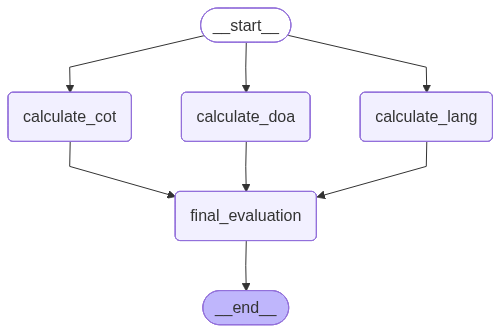

In [56]:
graph=StateGraph(UPSCState)

graph.add_node("calculate_cot",calculate_cot)
graph.add_node("calculate_doa",calculate_doa)
graph.add_node("calculate_lang",calculate_lang)



graph.add_node("final_evaluation",final_evaluation)


graph.add_edge(START,"calculate_cot")
graph.add_edge(START,"calculate_doa")
graph.add_edge(START,"calculate_lang")
graph.add_edge("calculate_cot","final_evaluation")
graph.add_edge("calculate_doa","final_evaluation")
graph.add_edge("calculate_lang","final_evaluation")
graph.add_edge("final_evaluation",END)


workflow=graph.compile()
workflow


In [58]:
initial_state={"essay":essay}
final_state=workflow.invoke(initial_state)

print("Final Feedback:",final_state['final_feedback'])

Final Feedback: Final Score: 7.0
Content Feedback: The essay provides a clear, concise, and well-structured overview of climate change. It effectively defines the concept, identifies human activities as primary drivers (burning fossil fuels, deforestation), and outlines the resulting increase in greenhouse gases. The discussion of consequences, including rising sea levels, severe weather, biodiversity loss, and impacts on agriculture and health, is comprehensive for its length. Furthermore, the essay proposes relevant solutions, emphasizing the need for global effort, emission reduction, and transition to renewable energy. The logical flow is excellent, moving smoothly from definition to causes, effects, and necessary actions. To achieve an even higher score, the essay could benefit from adding a specific example or two for each consequence (e.g., specific extreme weather events or endangered species) to make the impacts more concrete and vivid, though this is a minor point for a brief